In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from joblib import dump
import datetime
%matplotlib inline

In [3]:
import pandas as pd
store = pd.read_csv('../data/store.csv')
test_data = pd.read_csv('../data/test_data.csv')
train_data = pd.read_csv('../data/train_data.csv')

C:\Users\user\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\user\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
train_data.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,month,day_of_month
0,1,5,2015-07-31,5263.0,555.0,1,1,0,1,c,a,1270.0,9.0,2008.0,0,unknown,unknown,unknown,7,31
1,2,5,2015-07-31,6064.0,625.0,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",7,31


In [9]:
#head
day = train_data.filter(['Date','Customers', 'day_of_month','Sales'], axis=1)
day.head()

,Date,Customers,day_of_month,Sales
0,2015-07-31,555.0,31,5263.0
1,2015-07-31,625.0,31,6064.0
2,2015-07-31,821.0,31,8314.0
3,2015-07-31,609.0,31,13995.0
4,2015-07-31,559.0,31,4822.0


In [13]:
agg_day= day.groupby('Date').agg({'Sales':'mean'})
agg_day.head(3)

,Sales
Date,
2013-01-01,76.940754
2013-01-02,6051.894170
2013-01-03,5578.240359


<AxesSubplot:title={'center':'Total Sales per Day'}, xlabel='Date'>

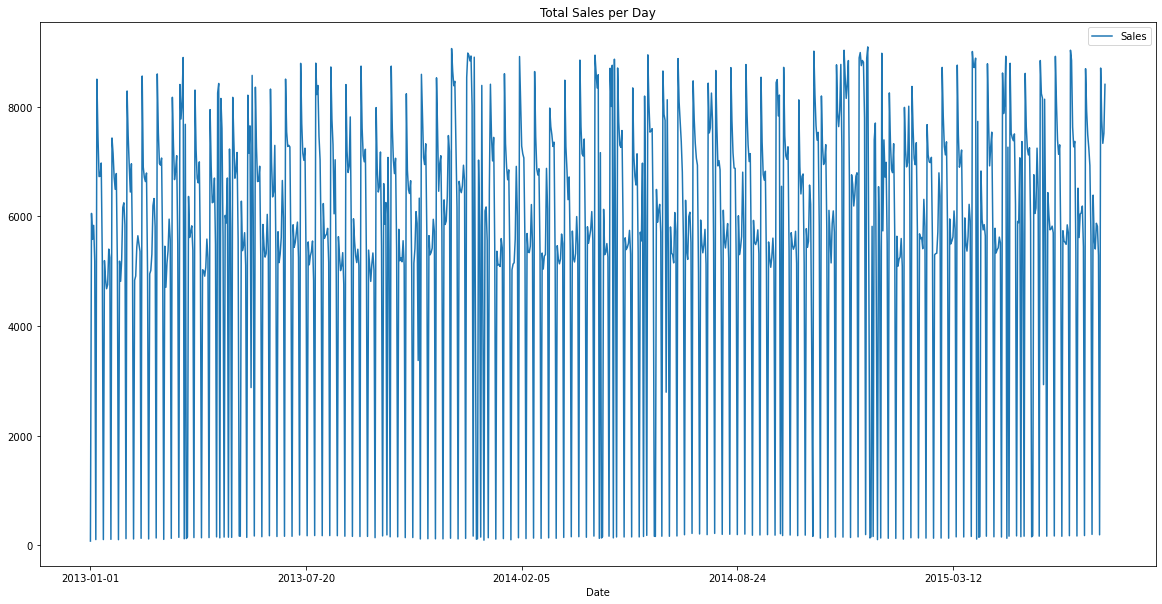

In [16]:
agg_day.plot(title="Total Sales per Day", figsize=(20, 10))

It is Stationary

In [17]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(agg_day)

In [18]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.002565
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568


The ADF value is below the 1% value so we can reject the null hypothesis (data is non-stationary) 
therefore, our data is stationary

In [19]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [21]:
acf_days = acf(agg_day["Sales"].values, fft=True, nlags=941)
acfNp = np.array(acf_days)
pacf_days = pacf(agg_day["Sales"].values, nlags=200)
pacfNp = np.array(pacf_days)

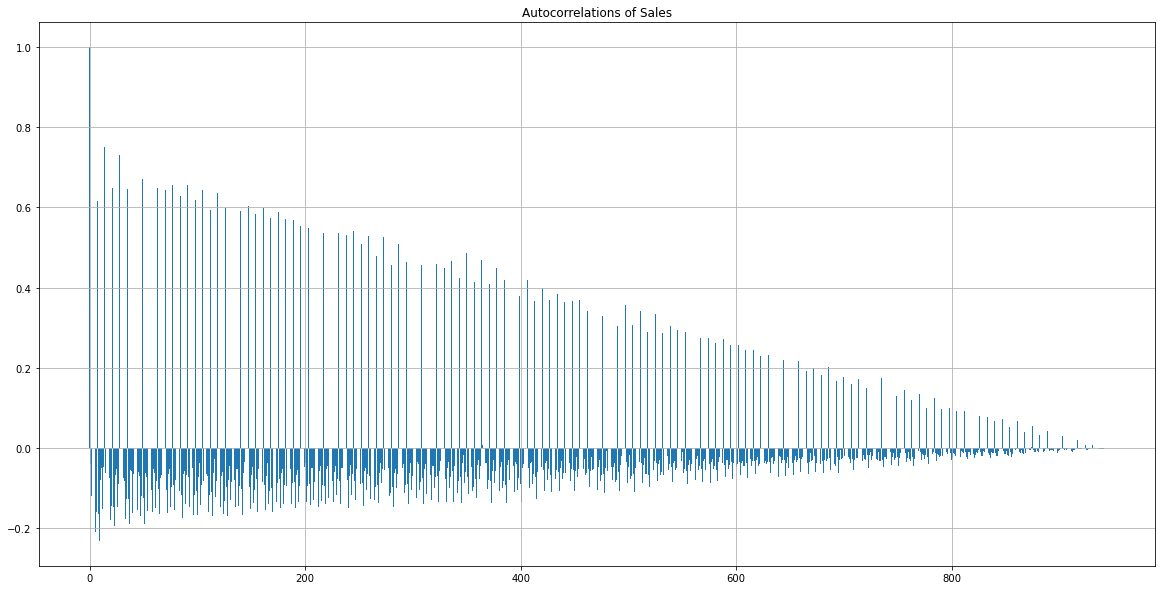

In [22]:
plt.figure(figsize=(20, 10))
plt.title("Autocorrelations of Sales")
plt.bar(range(len(acfNp)), acfNp)
plt.grid(True)

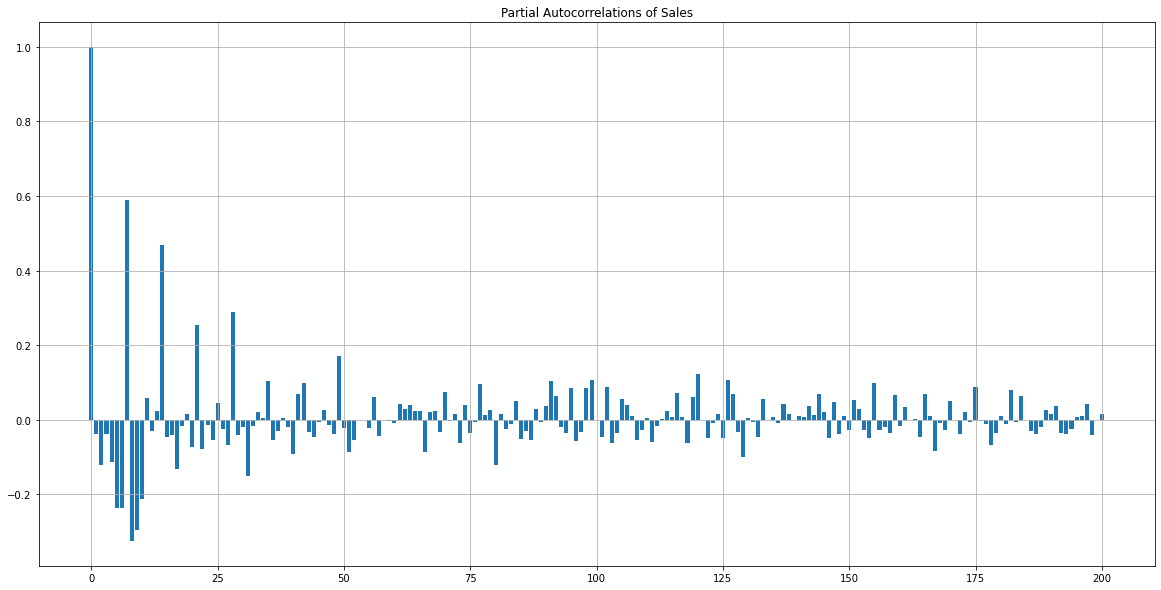

In [23]:
plt.figure(figsize=(20, 10))
plt.title(f"Partial Autocorrelations of Sales")
plt.bar(range(len(pacfNp)), pacfNp)
plt.grid(True)

In [24]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(agg_day["Sales"].values.reshape([-1, 1]))

MinMaxScaler(feature_range=(-1, 1))

In [26]:
agg_day_scaled = scaler.transform(agg_day["Sales"].values.reshape(-1, 1))

In [27]:
agg_day["Scaled"] = agg_day_scaled

In [28]:
agg_day

,Sales,Scaled
Date,,
2013-01-01,76.940754,-1.000000
2013-01-02,6051.894170,0.326221
2013-01-03,5578.240359,0.221087
2013-01-04,5833.756951,0.277802
2013-01-05,5179.874439,0.132664
...,...,...
2015-07-27,8701.607175,0.914360
2015-07-28,7746.570404,0.702376
2015-07-29,7329.012556,0.609694


In [29]:
SIZE = len(agg_day["Scaled"])
WINDOW_SIZE = 48
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 200

In [34]:
DateTrain = agg_day.index.values[0:BATCH_SIZE]
DateValid = agg_day.index.values[BATCH_SIZE:]
XTrain = agg_day["Scaled"].values[0:BATCH_SIZE].astype('float32')
XValid = agg_day["Scaled"].values[BATCH_SIZE:].astype('float32')

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

In [35]:
tf.random.set_seed(1234)
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([846, 1])

In [37]:
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float32, name=None)>

In [38]:
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True) 

In [39]:
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))

In [40]:
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

In [41]:
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [42]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE): 
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) 
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)


<h2>Define and Estimate the LSTM.

In [43]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="huber_loss", optimizer='adam')

The Huber loss is chosen because it is quite robust for non linear regression models and models with non normal errors.

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 8)           320       
                                                                 
 lstm_1 (LSTM)               (None, 4)                 208       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


In [45]:
history = model.fit(DatasetTrain, epochs=EPOCHS, validation_data=DatasetVal, verbose=1)

Epoch 1/200
1/1 [==============================] - 10s 10s/step - loss: 0.2002 - val_loss: 0.2132
Epoch 2/200
1/1 [==============================] - 1s 706ms/step - loss: 0.1983 - val_loss: 0.2105
Epoch 3/200
1/1 [==============================] - 1s 510ms/step - loss: 0.1965 - val_loss: 0.2080
Epoch 4/200
1/1 [==============================] - 0s 230ms/step - loss: 0.1947 - val_loss: 0.2056
Epoch 5/200
1/1 [==============================] - 0s 207ms/step - loss: 0.1930 - val_loss: 0.2033
Epoch 6/200
1/1 [==============================] - 0s 257ms/step - loss: 0.1914 - val_loss: 0.2010
Epoch 7/200
1/1 [==============================] - 0s 235ms/step - loss: 0.1898 - val_loss: 0.1988
Epoch 8/200
1/1 [==============================] - 0s 224ms/step - loss: 0.1884 - val_loss: 0.1967
Epoch 9/200
1/1 [==============================] - 0s 227ms/step - loss: 0.1869 - val_loss: 0.1947
Epoch 10/200
1/1 [==============================] - 0s 223ms/step - loss: 0.1855 - val_loss: 0.1927
Epoch 11/2

1/1 [==============================] - 0s 453ms/step - loss: 0.1614 - val_loss: 0.1511
Epoch 84/200
1/1 [==============================] - 0s 326ms/step - loss: 0.1613 - val_loss: 0.1509
Epoch 85/200
1/1 [==============================] - 0s 275ms/step - loss: 0.1613 - val_loss: 0.1507
Epoch 86/200
1/1 [==============================] - 0s 290ms/step - loss: 0.1612 - val_loss: 0.1505
Epoch 87/200
1/1 [==============================] - 0s 262ms/step - loss: 0.1611 - val_loss: 0.1503
Epoch 88/200
1/1 [==============================] - 0s 284ms/step - loss: 0.1610 - val_loss: 0.1501
Epoch 89/200
1/1 [==============================] - 0s 251ms/step - loss: 0.1610 - val_loss: 0.1499
Epoch 90/200
1/1 [==============================] - 0s 272ms/step - loss: 0.1609 - val_loss: 0.1498
Epoch 91/200
1/1 [==============================] - 0s 219ms/step - loss: 0.1608 - val_loss: 0.1496
Epoch 92/200
1/1 [==============================] - 0s 231ms/step - loss: 0.1607 - val_loss: 0.1495
Epoch 93/200


1/1 [==============================] - 0s 215ms/step - loss: 0.1553 - val_loss: 0.1359
Epoch 165/200
1/1 [==============================] - 0s 270ms/step - loss: 0.1553 - val_loss: 0.1357
Epoch 166/200
1/1 [==============================] - 0s 268ms/step - loss: 0.1552 - val_loss: 0.1356
Epoch 167/200
1/1 [==============================] - 0s 403ms/step - loss: 0.1551 - val_loss: 0.1355
Epoch 168/200
1/1 [==============================] - 0s 261ms/step - loss: 0.1551 - val_loss: 0.1354
Epoch 169/200
1/1 [==============================] - 0s 254ms/step - loss: 0.1550 - val_loss: 0.1353
Epoch 170/200
1/1 [==============================] - 0s 266ms/step - loss: 0.1549 - val_loss: 0.1351
Epoch 171/200
1/1 [==============================] - 0s 258ms/step - loss: 0.1549 - val_loss: 0.1350
Epoch 172/200
1/1 [==============================] - 0s 254ms/step - loss: 0.1548 - val_loss: 0.1349
Epoch 173/200
1/1 [==============================] - 0s 260ms/step - loss: 0.1547 - val_loss: 0.1348
Epoc

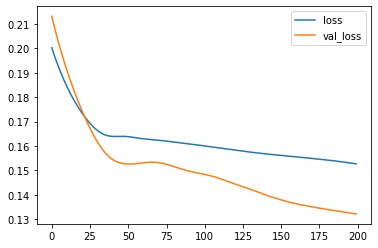

In [46]:
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()

In [47]:
def model_forecast(model, series, window_size,size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True) 
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(size).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [49]:
Forecast = model_forecast(model, agg_day["Scaled"].values[:, np.newaxis], WINDOW_SIZE, SIZE)
Results = Forecast[BATCH_SIZE-WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1,1))
XValid1 = scaler.inverse_transform(XValid.reshape(-1,1))

1/1 [==============================] - 1s 1s/step


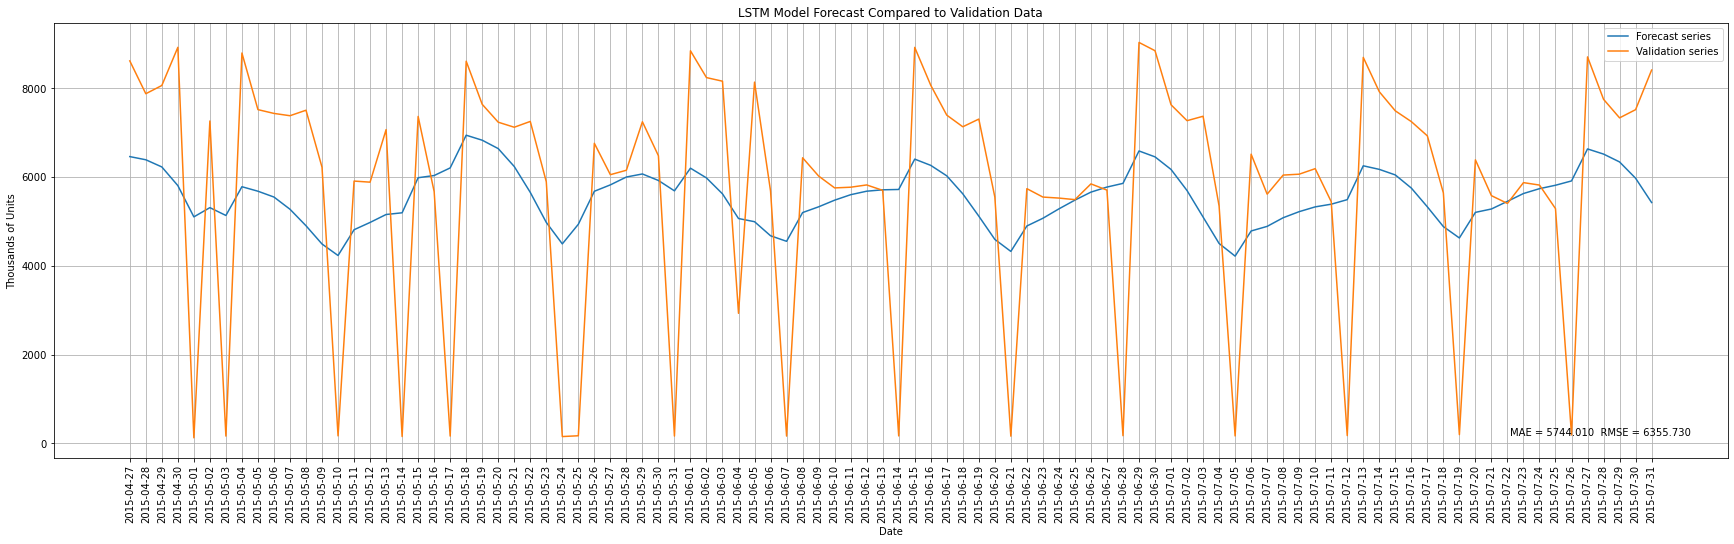

MAE = 5744.010  RMSE = 6355.730


In [50]:
plt.figure(figsize=(30, 8))
plt.title("LSTM Model Forecast Compared to Validation Data")
plt.plot(DateValid.astype('datetime64'), Results1, label='Forecast series')
plt.plot(DateValid.astype('datetime64'), np.reshape(XValid1, (2*WINDOW_SIZE, 1)), label='Validation series')
plt.xlabel('Date')
plt.ylabel('Thousands of Units')
plt.xticks(DateValid.astype('datetime64')[:,-1], rotation = 90) 
plt.legend(loc="upper right")

MAE = tf.keras.metrics.mean_absolute_error(XValid1[:,-1], Results[:,-1]).numpy()
RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(XValid1[:,-1], Results[:,-1]).numpy())

textstr = "MAE = " + "{:.3f}".format(MAE) + "  RMSE = " + "{:.3f}".format(RMSE)

# place a text box in upper left in axes coords
plt.annotate(textstr, xy=(0.87, 0.05), xycoords='axes fraction')
plt.grid(True)

plt.show()
print(textstr)